[View in Colaboratory](https://colab.research.google.com/github/sthalles/blog-resources/blob/master/sagan/Eager_SAGAN-STL-10-96x96.ipynb)

In [1]:
import tensorflow as tf
import numpy as np
print(tf.__version__)

tf.enable_eager_execution()
import matplotlib.pyplot as plt
from keras.datasets import cifar10
import os
from stl10_input import read_all_images

1.8.0
sys.version_info(major=3, minor=6, micro=5, releaselevel='final', serial=0)


Using TensorFlow backend.


In [2]:
#X_train = read_all_images("./data/stl10_binary/train_X.bin")
X_train, y_train = read_all_images("./data/stl10_binary/train_X.bin", "./data/stl10_binary/train_y.bin")

X_test, y_test = read_all_images("./data/stl10_binary/test_X.bin", "./data/stl10_binary/test_y.bin")

X_train = np.concatenate((X_train, X_test), axis=0)
y_train = np.concatenate((y_train, y_test), axis=0)
y_train = y_train - 1

In [3]:
print("Train data shape:", X_train.shape)
print("Train labels shape:", y_train.shape)
print("Test data shape:", X_test.shape)
print("Test labels shape:", y_test.shape)

print("Max value:", np.max(X_train))
print("Min value:", np.min(X_train))

print("Max label value:", np.max(y_train))
print("Min label value:", np.min(y_train))


Train data shape: (13000, 96, 96, 3)
Train labels shape: (13000,)
Test data shape: (8000, 96, 96, 3)
Test labels shape: (8000,)
Max value: 255
Min value: 0
Max label value: 9
Min label value: 0


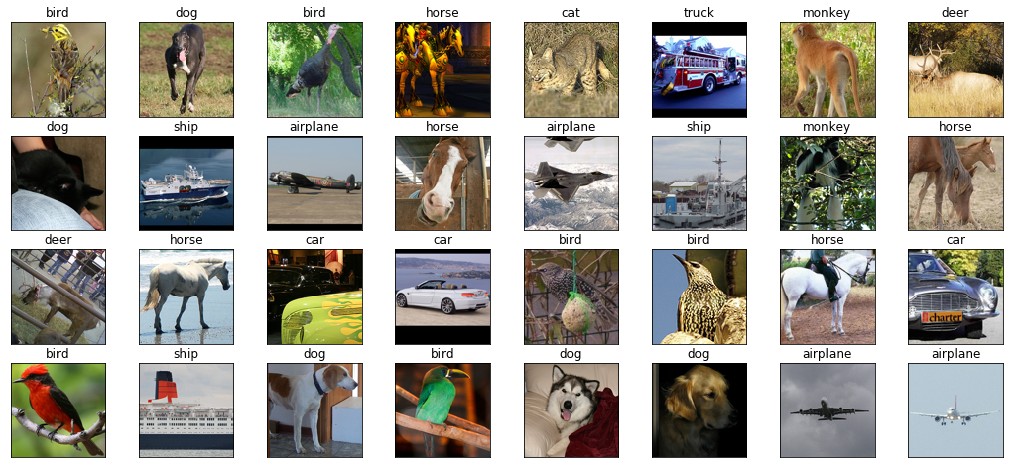

In [4]:
labels = ["airplane", "bird", "car", "cat", "deer", "dog", "horse", "monkey", "ship", "truck"]
n_classes = 10
fig = plt.figure(figsize=(18,8))
n_columns = 8
n_rows = 4

for i in range(0,n_columns*n_rows):

  fig.add_subplot(n_rows, n_columns, i+1)
  plt.imshow(X_train[i])
  #print(y_train[i-1])
  plt.title(labels[y_train[i]])
  # Turn off tick labels
  plt.xticks([])
  plt.yticks([])
plt.show()

In [5]:
tfe = tf.contrib.eager

In [6]:
class SelfAttention(tf.keras.Model):
  def __init__(self, number_of_filters):
    super(SelfAttention, self).__init__(number_of_filters)
    
    self.f = tf.keras.layers.Conv2D(number_of_filters//8, 1, 
                                     strides=1, padding='SAME', 
                                     activation=None)
    
    self.g = tf.keras.layers.Conv2D(number_of_filters//8, 1, 
                                     strides=1, padding='SAME', 
                                     activation=None)
    
    self.h = tf.keras.layers.Conv2D(number_of_filters, 1, 
                                     strides=1, padding='SAME', 
                                     activation=None)
    
    self.scale = tfe.Variable(0., trainable=True)
    self.flatten = tf.keras.layers.Flatten()
    
  def call(self, x):
    input_shape = tf.shape(x)
    f = self.f(x)
    g = self.g(x)
    h = self.h(x)
    
    f_flatten = self.flatten(f)
    g_flatten = self.flatten(g)
    h_flatten = self.flatten(h)
    
    s = tf.matmul(g_flatten, f_flatten, transpose_b=True)
    b = tf.nn.softmax(s, axis=-1)
    o = tf.matmul(b, h_flatten)
    y = self.scale * tf.reshape(o, tf.shape(x)) + x

    return y

![alt text](./images/sngan_network_architecture.png?raw=1)

In [7]:
z_size = 128
learning_rate_generator = 0.0001
learning_rate_discriminator = 0.0004
batch_size = 64
alpha = 0.1
beta1 = 0.0
beta2 = 0.9
bn_momentum = 0.1
bn_epsilon  = 0.00002
total_train_steps = 200000

In [8]:
from libs.conv_spectral_norm import Conv2D, Conv2DTranspose

In [9]:
class Generator(tf.keras.Model):
  def __init__(self):
    super(Generator, self).__init__()
    # define the generator's layers
    
    self.fc1 = tf.keras.layers.Dense(units=6*6*512, activation="relu")

    self.transp_conv1 = Conv2DTranspose(256, 4, spectral_normalization=True, strides=2, padding="SAME", activation=None)
    
    # BN + ReLU
    self.bn1 = tf.keras.layers.BatchNormalization(scale=False, epsilon=bn_epsilon, momentum=bn_momentum)
    self.activation1 = tf.keras.layers.Activation(activation='relu')
    
    self.transp_conv2 = Conv2DTranspose(128, 4, spectral_normalization=True, strides=2, padding="SAME", activation=None)
    
    # BN + ReLU
    self.bn2 = tf.keras.layers.BatchNormalization(scale=False, epsilon=bn_epsilon, momentum=bn_momentum)
    self.activation2 = tf.keras.layers.Activation(activation='relu')
    
    self.transp_conv3 = Conv2DTranspose(64, 4, spectral_normalization=True, strides=2, padding="SAME", activation=None)
    
    self.bn3 = tf.keras.layers.BatchNormalization(scale=False, epsilon=bn_epsilon, momentum=bn_momentum)
    self.activation3 = tf.keras.layers.Activation(activation='relu')
    
    # pass the number of filters of the current feature volume
    self.attention = SelfAttention(64)

    self.transp_conv4 = Conv2DTranspose(32, 4, spectral_normalization=True, strides=2, padding="SAME", activation=None)
    
    self.bn4 = tf.keras.layers.BatchNormalization(scale=False, epsilon=bn_epsilon, momentum=bn_momentum)
    self.activation4 = tf.keras.layers.Activation(activation='relu')
    
    self.conv = Conv2D(3, 3, strides=1, spectral_normalization=True, padding='SAME', activation=None)
    self.out = tf.keras.layers.Activation(activation='tanh')
    
  def call(self, z, is_training):

    fc1 = self.fc1(z)
    fc1_reshaped = tf.reshape(fc1, (-1,6,6,512))

    trans_conv1 = self.transp_conv1(fc1_reshaped, training=is_training)
    bn1 = self.bn1(trans_conv1, training=is_training)
    activation1 = self.activation1(bn1)

    transp_conv2 = self.transp_conv2(activation1, training=is_training)
    bn2 = self.bn2(transp_conv2, training=is_training)
    activation2 = self.activation2(bn2)
 
    transp_conv3 = self.transp_conv3(activation2, training=is_training)
    bn3 = self.bn3(transp_conv3, training=is_training)
    activation3 = self.activation3(bn3)

    attention = self.attention(activation3)

    transp_conv4 = self.transp_conv4(attention, training=is_training)
    bn4 = self.bn4(transp_conv4, training=is_training)
    activation4 = self.activation4(bn4)

    conv = self.conv(activation4, training=is_training)
    output = self.out(conv)
    
    return output

In [10]:
class Discriminator(tf.keras.Model):
  def __init__(self, alpha):
    super(Discriminator, self).__init__()
    
    # -------- Block 1
    self.conv1 = Conv2D(32, 3, spectral_normalization=True, strides=1, padding='SAME', activation=None)
    self.activation1 = tf.keras.layers.LeakyReLU(alpha=alpha)
  
    self.conv2 = Conv2D(32, 4, spectral_normalization=True, strides=2, padding='SAME', activation=None)
    self.activation2 = tf.keras.layers.LeakyReLU(alpha=alpha)
    
    # pass the number of filters of the current feature volume
    self.attention = SelfAttention(32)
    
    # -------- Block 2
    self.conv3 = Conv2D(64, 3, spectral_normalization=True, strides=1, padding='SAME', activation=None)
    self.activation3 = tf.keras.layers.LeakyReLU(alpha=alpha)
    
    self.conv4 = Conv2D(64, 4, spectral_normalization=True, strides=2, padding='SAME', activation=None)
    self.activation4 = tf.keras.layers.LeakyReLU(alpha=alpha)
    
    # -------- Block 3
    self.conv5 = Conv2D(128, 3, spectral_normalization=True, strides=1, padding='SAME', activation=None)
    self.activation5 = tf.keras.layers.LeakyReLU(alpha=alpha)
    
    self.conv6 = Conv2D(128, 4, spectral_normalization=True, strides=2, padding='SAME', activation=None)
    self.activation6 = tf.keras.layers.LeakyReLU(alpha=alpha)
    
    # -------- Block 4
    self.conv7 = Conv2D(256, 3, spectral_normalization=True, strides=1, padding='SAME', activation=None)
    self.activation7 = tf.keras.layers.LeakyReLU(alpha=alpha)
    
    self.conv8 = Conv2D(256, 4, spectral_normalization=True, strides=2, padding='SAME', activation=None)
    self.activation8 = tf.keras.layers.LeakyReLU(alpha=alpha)
    # --------
    
    self.conv9 = Conv2D(512, 3, spectral_normalization=True, strides=1, padding='SAME', activation=None)
    self.activation9 = tf.keras.layers.LeakyReLU(alpha=alpha)
    
    self.fc1 = tf.keras.layers.Dense(units=1, activation=None)
    self.embed_layer = tf.keras.layers.Embedding(10, 512)
  
  def call(self, inputs, is_training, labels=None):

    conv1 = self.conv1(inputs, training=is_training)
    activation1 = self.activation1(conv1)
        
    conv2 = self.conv2(activation1, training=is_training)
    activation2 = self.activation2(conv2)
    
    attention = self.attention(activation2)

    conv3 = self.conv3(attention, training=is_training)
    activation3 = self.activation3(conv3)
    
    conv4 = self.conv4(activation3, training=is_training)
    activation4 = self.activation4(conv4)
    
    conv5 = self.conv5(activation4, training=is_training)
    activation5 = self.activation5(conv5)
    
    conv6 = self.conv6(activation5, training=is_training)
    activation6 = self.activation6(conv6)
    
    conv7 = self.conv7(activation6, training=is_training)
    activation7 = self.activation7(conv7)
    
    conv8 = self.conv8(activation7, training=is_training)
    activation8 = self.activation8(conv8)
    
    conv9 = self.conv9(activation8, training=is_training)
    activation9 = self.activation9(conv9)

    # globa sum pooling
    global_pool = tf.reduce_sum(activation9, axis=[1,2])

    logits = self.fc1(global_pool)
    
    if labels is not None:
        # get the corresponding word embeddings
        embeddings = self.embed_layer(labels)
        #print("embeddings", embeddings.shape)
        logits += tf.reduce_sum(embeddings * global_pool, axis=1, keepdims=True)
    
    return logits

In [11]:
generator_net = Generator()
discriminator_net = Discriminator(alpha=alpha)

In [12]:
def generator_loss(d_logits_fake):
  return - tf.reduce_mean(d_logits_fake)

In [13]:
def discriminator_loss(d_logits_real, d_logits_fake):
  return tf.reduce_mean(- tf.minimum(0, -1. + d_logits_real)) - tf.reduce_mean(tf.minimum(0, -1. - d_logits_fake))

In [14]:
logdir = "./checkpoints/logs/"
tf_board_writer = tf.contrib.summary.create_file_writer(logdir)
tf_board_writer.set_as_default()

generator_optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate_generator, beta1=beta1, beta2=beta2)
discriminator_optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate_discriminator, beta1=beta1, beta2=beta2)

In [15]:
gen_global_counter = tfe.Variable(0, trainable=False, dtype=tf.int32)
disc_global_counter = tfe.Variable(0, trainable=False, dtype=tf.int32)

In [16]:
gen_checkpoint_dir  = "./checkpoints/generator"
gen_checkpoint_prefix = os.path.join(gen_checkpoint_dir, "model.ckpt")
gen_root = tfe.Checkpoint(optimizer=generator_optimizer,
                      model=generator_net,
                      optimizer_step=gen_global_counter)

disc_checkpoint_dir = "./checkpoints/discriminator"
disc_checkpoint_prefix = os.path.join(disc_checkpoint_dir, "model.ckpt")
disc_root = tfe.Checkpoint(optimizer=discriminator_optimizer,
                      model=discriminator_net,
                      optimizer_step=disc_global_counter)

In [17]:
def normalizer(image, label):
  # image = tf.image.resize_images(image, (48,48))
  image = 2 * tf.to_float(image) / 255.0 - 1.0
  return image, label

In [18]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.map(normalizer)
train_dataset = train_dataset.shuffle(1000)
train_dataset = train_dataset.repeat()
train_dataset = train_dataset.batch(batch_size)

In [19]:
def display_images(dataset, denomalize=True):
    fig, axes = plt.subplots(6, 6, sharex=True, sharey=True, figsize=(8,8))
    for ii, ax in enumerate(axes.flatten()):
        img = dataset[ii,:,:,:]
        if denomalize:
            img = ((img + 1)*255 / 2).astype(np.uint8) # Scale back to 0-255
        ax.imshow(img, aspect='equal')
      
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()

In [20]:
def save_model(root, checkpoint_prefix):
    root.save(file_prefix=checkpoint_prefix)

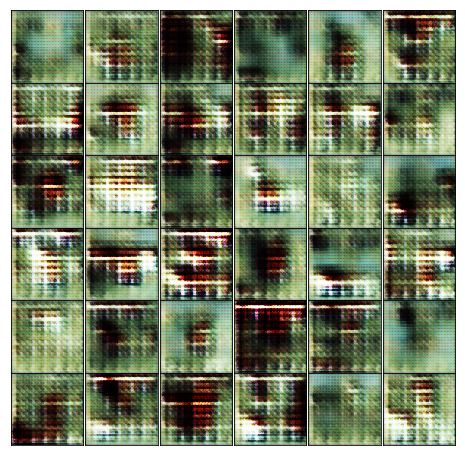

In [ ]:
# generate sample noise for evaluation
fake_input_test = tf.random_normal(shape=(36, z_size), dtype=tf.float32)

for _, (batch_real_images, batch_real_labels) in enumerate(train_dataset):
  fake_input = tf.random_normal(shape=(batch_size, z_size), dtype=tf.float32)
  fake_labels = tf.constant(np.random.randint(low=0, high=n_classes, size=(batch_size)).astype(np.int32))

  batch_real_images = tf.to_float(batch_real_images)

  with tf.contrib.summary.record_summaries_every_n_global_steps(100):

      with tf.GradientTape() as g_tape, tf.GradientTape() as d_tape:

        # run the generator with the random noise batch
        g_model = generator_net(fake_input, is_training=True)

        # run the discriminator with real input images
        d_logits_real = discriminator_net(batch_real_images, labels=batch_real_labels, is_training=True)

        # run the discriminator with fake input images (images from the generator)
        d_logits_fake = discriminator_net(g_model, labels=fake_labels, is_training=True)

        # compute the generator loss
        gen_loss = generator_loss(d_logits_fake)

        # compute the discriminator loss
        dis_loss = discriminator_loss(d_logits_real, d_logits_fake)
    
        #tf.contrib.summary.scalar('generator_loss', gen_loss)
        #tf.contrib.summary.scalar('discriminator_loss', dis_loss)
        tf.contrib.summary.image('generator_image', g_model, max_images=1)
        
  discriminator_grads = d_tape.gradient(dis_loss, discriminator_net.variables)
  generator_grads = g_tape.gradient(gen_loss, generator_net.variables)
  
  discriminator_optimizer.apply_gradients(zip(discriminator_grads, discriminator_net.variables), global_step=disc_global_counter)
  generator_optimizer.apply_gradients(zip(generator_grads, generator_net.variables), global_step=gen_global_counter)
      
  counter = gen_global_counter.numpy()
    
  if counter % 2000 == 0:
    generated_samples = generator_net(fake_input_test, is_training=False)
    display_images(generated_samples.numpy())

  if counter % 15000 == 0:
    # save and download the mode
    save_model(gen_root, gen_checkpoint_prefix)
    save_model(disc_root, disc_checkpoint_prefix)
    #zip_and_download("./checkpoints")
    
  if counter >= total_train_steps:
    save_model(gen_root, gen_checkpoint_prefix)
    save_model(disc_root, disc_checkpoint_prefix)
    #zip_and_download("./checkpoints")
    break